In [45]:
import numpy as np
import pickle
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import cherenkov_rings
reload(cherenkov_rings)

<module 'cherenkov_rings' from '/home/jpyanez/snoplus/snoplus_python/cherenkov_rings.pyc'>

In [46]:
import ROOT, rat

In [47]:
# Airplane mode
db = rat.RAT.DB.Get()
db.SetAirplaneModeStatus(True)
db.SetDefaultPlaneLockStatus(False)
print 'This is AIRPLANE MODE - be careful!'

This is AIRPLANE MODE - be careful!


In [48]:
light_speed = 0.299792458*1000 # mm/ns

In [49]:
pmt_info = pickle.load(open('/home/jpyanez/snoplus/snoplus_python/pmt_positions.pckl'))
pmt_radii = np.linalg.norm(pmt_info['xyz'], axis=1)
costheta = pmt_info['xyz'][:,2]/pmt_radii
phi      = np.arctan2(pmt_info['xyz'][:,1], 
                      pmt_info['xyz'][:,0])


In [50]:
effective_n = 1.4

In [51]:
pmts_ring = cherenkov_rings.PMTsInRing(effective_n = effective_n)

Using cherenkov angle 44.4153085972


In [52]:
#infile_name = '/home/jpyanez/snoplus/reconstruction/jie_files/FitMPW1p38486_Analysis_r0000100438_s000_p000_unclean.root'
#infile_name = '/home/jpyanez/snoplus/reconstruction/jie_files/FitMPW1p38486_Analysis_r0000100207_s001_p002_unclean.root'
infile_name = '/home/jpyanez/snoplus/reconstruction/jie_files/FitMPW_1p38486_modeCut75_tResCut_Analysis_r0000100667_s002_p001.root'

In [53]:
reader = rat.dsreader(infile_name)
counter = 0

Selected PMTs: 0


ValueError: zero-size array to reduction operation minimum which has no identity

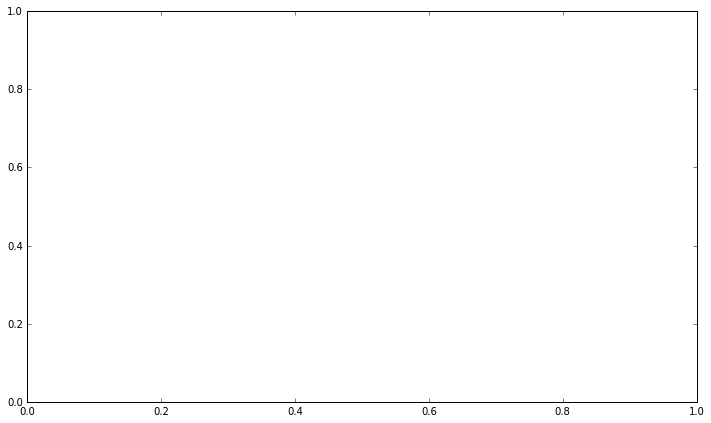

In [105]:
for ds, run in reader:
    event_bool = np.zeros_like(pmt_info['type'],dtype=bool)
    event_times = np.zeros_like(pmt_info['type'])
    
    # Assuming ONE event per trigger
    event = ds.GetEV(0)
    pmts  = event.GetCalPMTs()
    if pmts.GetNormalCount() < 1:
        print 'Not enough PMTs in event'
        continue
        
    for iPMT in range(pmts.GetNormalCount()):
        one_pmt = pmts.GetPMT(iPMT)
        event_bool[int(one_pmt.GetID())]= True
        event_times[int(one_pmt.GetID())] = one_pmt.GetTime()
    

    
    
    # Reconstruction information
    fit = event.GetFitResult(event.GetFitNames()[0])
    vertex = fit.GetVertex(0)
    fit_vertex = np.array(vertex.GetPosition())
    fit_direction = np.array(vertex.GetDirection())
    pmts_cone_fit = pmts_ring(position = fit_vertex,
                              direction = fit_direction)
    pmt_fit_distance = np.linalg.norm(pmt_info['xyz'][pmts_cone_fit,:] - fit_vertex,axis=1)
    pmt_toa_fit = vertex.GetTime() + pmt_fit_distance/(light_speed/effective_n)

    

    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    
    plt.scatter(phi[pmts_cone_fit]/np.pi, costheta[pmts_cone_fit], 
                c = pmt_toa_fit, cmap = 'jet',
                vmin=pmt_toa_fit.min()-10, vmax=pmt_toa_fit.max()+10, s=80,
                marker='x',lw = 2, label=event.GetFitNames()[0] + ' expected')

    plt.scatter(phi[event_bool]/np.pi, costheta[event_bool],
                c = event_times[event_bool], cmap = 'jet',
                vmin=pmt_toa_fit.min()-10, vmax=pmt_toa_fit.max()+10, s=110,
                marker='+',lw = 2, label='Observed')
    plt.colorbar()
    
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel('Phi / pi')
    plt.ylabel('cos(theta)')
    plt.legend(loc=0)
    plt.title('Event ' + "%i" % counter)
    
    plt.show()
    counter += 1
    break #raw_input()
        
#reader.close()

In [81]:
event.GetFitNames()[0]

'MultiPathProcessor'

In [82]:
event.GetCalPMTs().GetCount()

10L

In [83]:
print event_times[event_bool]

[   142.39807129    236.73612976 -99999.            183.39353943
    229.26071167 -99999.         -99999.         -99999.         -99999.
    158.65774536]


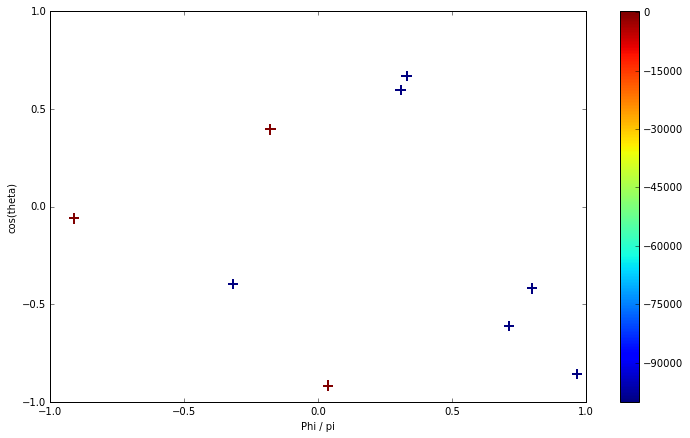

In [60]:
fig = plt.figure(figsize=(12,7))
plt.scatter(phi[event_bool]/np.pi, costheta[event_bool],
            c = event_times[event_bool], cmap = 'jet',
            #vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10, 
            s=110,
            marker='+',lw = 2)
plt.colorbar()
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('Phi / pi')
plt.ylabel('cos(theta)')

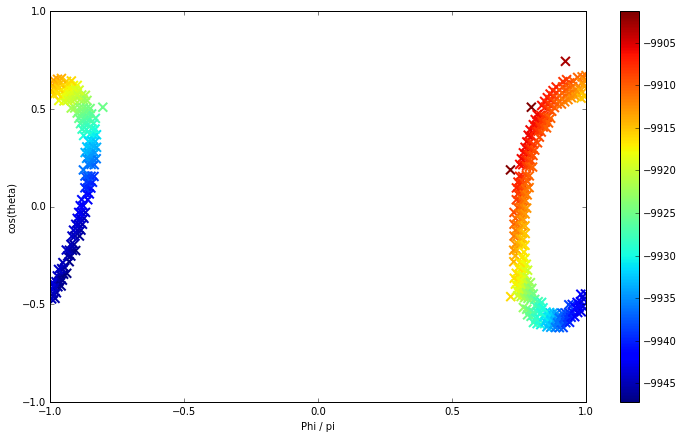

In [39]:
fig = plt.figure(figsize=(12,7))
plt.scatter(phi[pmts_cone_fit]/np.pi, costheta[pmts_cone_fit], 
            c = pmt_toa_fit, cmap = 'jet',
            #vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10, 
            s=80,
            marker='x',lw = 2)
plt.colorbar()
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('Phi / pi')
plt.ylabel('cos(theta)')

In [69]:
reader.close()